In [1]:
!pip install openvino-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.5.4-cp37-cp37m-manylinux1_x86_64.whl (25.9 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [2]:
# !pip install notebook

In [3]:
#restart after installing OpenVINO

In [4]:
import os
import sys
from pathlib import Path

import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow
from PIL import Image
from openvino.runtime import Core
from openvino.tools.mo import mo_tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

sys.path.append("../utils")
#from notebook_utils import download_file

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


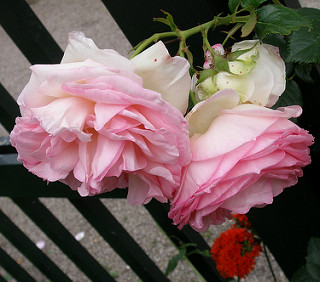

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

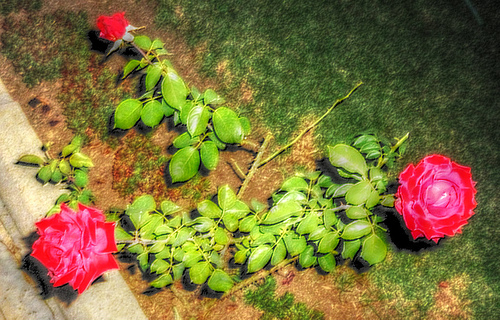

In [8]:
PIL.Image.open(str(roses[1]))

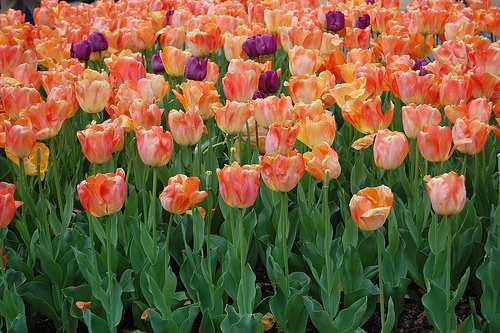

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

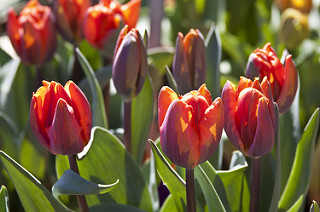

In [10]:
PIL.Image.open(str(tulips[1]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


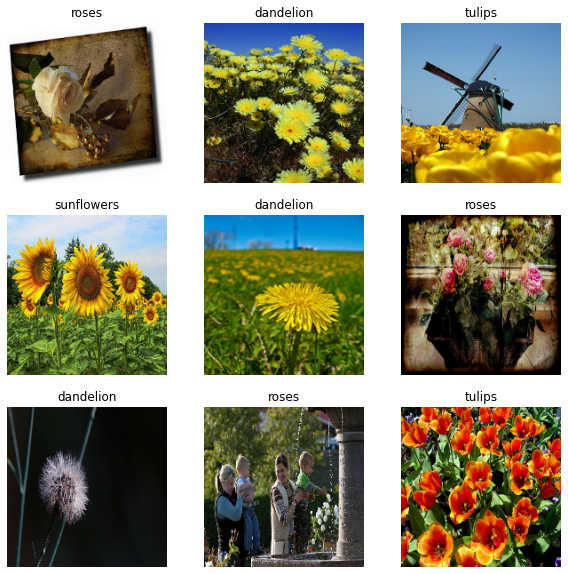

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [17]:
# AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

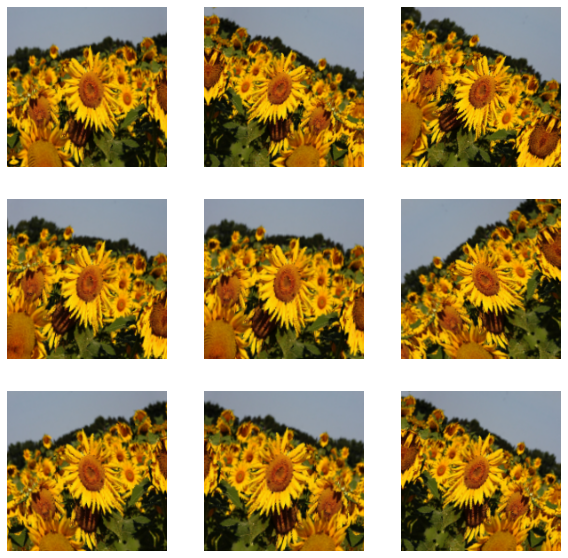

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [52]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [54]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 47ms/step - loss: 1.3534 - accuracy: 0.4111 - val_loss: 1.0677 - val_accuracy: 0.5695
Epoch 2/15
92/92 [==============================] - 4s 43ms/step - loss: 1.0578 - accuracy: 0.5702 - val_loss: 1.0055 - val_accuracy: 0.5967
Epoch 3/15
92/92 [==============================] - 4s 44ms/step - loss: 0.9319 - accuracy: 0.6301 - val_loss: 0.9413 - val_accuracy: 0.6308
Epoch 4/15
92/92 [==============================] - 4s 44ms/step - loss: 0.8680 - accuracy: 0.6540 - val_loss: 0.8752 - val_accuracy: 0.6471
Epoch 5/15
92/92 [==============================] - 4s 43ms/step - loss: 0.7998 - accuracy: 0.6931 - val_loss: 0.8385 - val_accuracy: 0.6621
Epoch 6/15
92/92 [==============================] - 4s 44ms/step - loss: 0.7608 - accuracy: 0.7044 - val_loss: 0.8755 - val_accuracy: 0.6703
Epoch 7/15
92/92 [==============================] - 4s 45ms/step - loss: 0.7191 - accuracy: 0.7265 - val_loss: 0.7722 - val_accuracy: 0.6880
Epoch 8/15
92

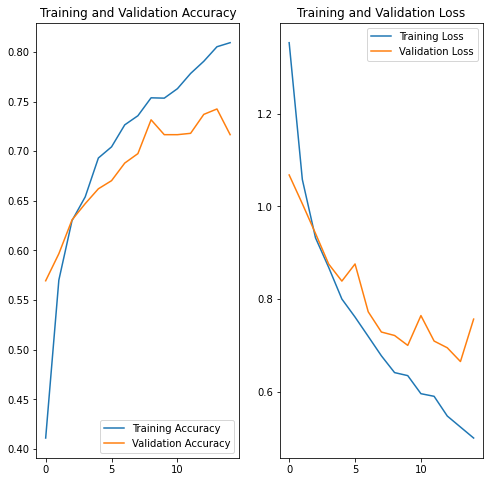

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to sunflowers with a 94.30 percent confidence.
Normal Time : [0.5673048496246338, 1.0371606349945068, 1.7606918811798096, 2.679621696472168, 2.868990421295166, 3.4850471019744873, 4.015448093414307, 4.987256288528442, 5.397173166275024, 5.958722352981567]


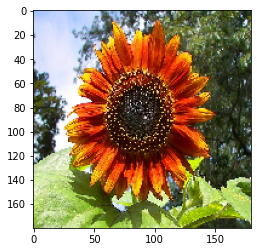

In [67]:
import time

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

tf_time=[]
for i in range(1,11):
  start=time.time()
  for j in range(i*10):
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
  tf_time.append(time.time()-start)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print("Normal Time :",tf_time)
plt.imshow(img)


In [29]:
#save the trained model - a new folder flower will be created
#and the file "saved_model.pb" is the pre-trained model
model_dir = "model"
model_fname = f"{model_dir}/flower"
model.save(model_fname)

In [30]:
# The paths of the source and converted models
model_name = "flower"
model_path = Path(model_fname)
ir_data_type = "FP16"
ir_model_name = "flower_ir"

# Get the path to the Model Optimizer script

# Construct the command for Model Optimizer
mo_command = f"""mo
                 --saved_model_dir "{model_fname}"
                 --input_shape "[1,180,180,3]"
                 --data_type "{ir_data_type}"
                 --output_dir "{model_fname}"
                 --model_name "{ir_model_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
print(mo_command)

Model Optimizer command to convert TensorFlow to OpenVINO:
mo --saved_model_dir "model/flower" --input_shape "[1,180,180,3]" --data_type "FP16" --output_dir "model/flower" --model_name "flower_ir"


In [31]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/model/flower
	- IR output name: 	flower_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,180,180,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Fro

In [32]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/model/flower
	- IR output name: 	flower_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,180,180,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Fro

In [39]:
from PIL import Image
def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

In [34]:
class_names=["daisy", "dandelion", "roses", "sunflowers", "tulips"]

model_xml = f"{model_fname}/flower_ir.xml"

# Load model
ie = Core()
model = ie.read_model(model=model_xml)

# Neural Compute Stick
# compiled_model = ie.compile_model(model=model, device_name="MYRIAD")
compiled_model = ie.compile_model(model=model, device_name="CPU")

del model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [35]:
import os
import socket
import threading
import time
import urllib
import urllib.parse
import urllib.request
from os import PathLike
from pathlib import Path
from typing import Callable, List, NamedTuple, Optional, Tuple

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core, get_version
# from async_pipeline import AsyncPipeline
from IPython.display import HTML, Image, Markdown, display
from matplotlib.lines import Line2D
# from tensorflow.keras.models import model
from tqdm.notebook import tqdm_notebook

In [36]:
class DownloadProgressBar(tqdm_notebook):
    """
    TQDM Progress bar for downloading files with urllib.request.urlretrieve
    """

    def update_to(self, block_num: int, block_size: int, total_size: int):
        downloaded = block_num * block_size
        if downloaded <= total_size:
            self.update(downloaded - self.n)

In [37]:
def download_file(
    url,
    filename= None,
    directory= None,
    show_progress= True,
    silent= False,
    timeout= 10):
    """
    Download a file from a url and save it to the local filesystem. The file is saved to the
    current directory by default, or to `directory` if specified. If a filename is not given,
    the filename of the URL will be used.
    :param url: URL that points to the file to download
    :param filename: Name of the local file to save. Should point to the name of the file only,
                     not the full path. If None the filename from the url will be used
    :param directory: Directory to save the file to. Will be created if it doesn't exist
                      If None the file will be saved to the current working directory
    :param show_progress: If True, show an TQDM ProgressBar
    :param silent: If True, do not print a message if the file already exists
    :param timeout: Number of seconds before cancelling the connection attempt
    :return: path to downloaded file
    """
    try:
        opener = urllib.request.build_opener()
        opener.addheaders = [("User-agent", "Mozilla/5.0")]
        urllib.request.install_opener(opener)
        urlobject = urllib.request.urlopen(url, timeout=timeout)
        if filename is None:
            filename = urlobject.info().get_filename() or Path(urllib.parse.urlparse(url).path).name
    except urllib.error.HTTPError as e:
        raise Exception(f"File downloading failed with error: {e.code} {e.msg}") from None
    except urllib.error.URLError as error:
        if isinstance(error.reason, socket.timeout):
            raise Exception(
                "Connection timed out. If you access the internet through a proxy server, please "
                "make sure the proxy is set in the shell from where you launched Jupyter. If your "
                "internet connection is slow, you can call `download_file(url, timeout=30)` to "
                "wait for 30 seconds before raising this error."
            ) from None
        else:
            raise

    filename = Path(filename)
    if len(filename.parts) > 1:
        raise ValueError(
            "`filename` should refer to the name of the file, excluding the directory. "
            "Use the `directory` parameter to specify a target directory for the downloaded file."
        )

    # create the directory if it does not exist, and add the directory to the filename
    if directory is not None:
        directory = Path(directory)
        directory.mkdir(parents=True, exist_ok=True)
        filename = directory / Path(filename)

    # download the file if it does not exist, or if it exists with an incorrect file size
    urlobject_size = int(urlobject.info().get("Content-Length", 0))
    if not filename.exists() or (os.stat(filename).st_size != urlobject_size):
        progress_callback = DownloadProgressBar(
            total=urlobject_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc=str(filename),
            disable=not show_progress,
        )
        urllib.request.urlretrieve(url, filename, reporthook=progress_callback.update_to)
        if os.stat(filename).st_size >= urlobject_size:
            progress_callback.update(urlobject_size - progress_callback.n)
            progress_callback.refresh()
    else:
        if not silent:
            print(f"'{filename}' already exists.")
    return filename.resolve()

output_folder
'output_folder/Given Input Image.jpg' already exists.

 (1, 180, 180, 3)
{1, 180, 180, 3} 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  


OpenVINO Time : [0.04300975799560547, 0.08000063896179199, 0.11998772621154785, 0.16261720657348633, 0.21418428421020508, 0.25069475173950195, 0.3415048122406006, 0.3659656047821045, 0.40761351585388184, 0.41593098640441895]
[0.5673048496246338, 1.0371606349945068, 1.7606918811798096, 2.679621696472168, 2.868990421295166, 3.4850471019744873, 4.015448093414307, 4.987256288528442, 5.397173166275024, 5.958722352981567]
 
 Given image highly likely corresponds to sunflowers with a 74.26 percent confidence.


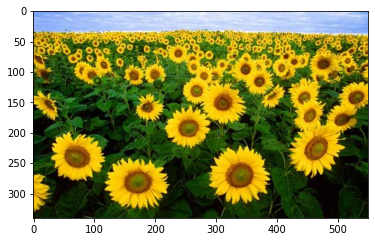

In [68]:
# Run inference on the input image...
inp_img_url = "https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg"
OUTPUT_DIR = "output_folder"
inp_file_name = f"Given Input Image.jpg"
file_path = Path(OUTPUT_DIR)/Path(inp_file_name)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the image
# import requests

# img_data = requests.get(image_url).content
# with open('image_name.jpg', 'wb') as handler:
#     handler.write(img_data)
print(OUTPUT_DIR)
download_file(inp_img_url, inp_file_name, directory=OUTPUT_DIR)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(file_path)
import time
print('\n',input_image.shape)
print(input_layer.shape,"\n")
OpenVINO_time=[]
for i in range(1,11):
  start=time.time()
  for j in range(i*10):
    res = compiled_model([input_image])[output_layer]

  score = tf.nn.softmax(res[0])
  OpenVINO_time.append(time.time()-start)
print("OpenVINO Time :",OpenVINO_time)
print(tf_time)
# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    " \n Given image highly likely corresponds to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score),end='\n')
)

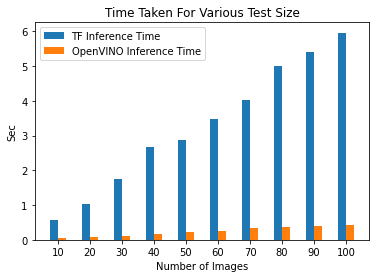

In [71]:
import numpy as np
labels = [i*10 for i in range(1,11)]


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tf_time, width, label='TF Inference Time')
rects2 = ax.bar(x + width/2, OpenVINO_time, width, label='OpenVINO Inference Time')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sec')
ax.set_xlabel('Number of Images')
ax.set_title('Time Taken For Various Test Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();
fig.savefig("bar_inference.pdf")

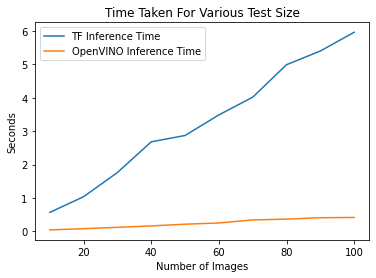

In [74]:
fig = plt.figure()
ax = plt.axes()

ax.plot(labels, tf_time, label = 'TF Inference Time')
ax.plot(labels, OpenVINO_time, label = 'OpenVINO Inference Time')
ax.set_title('Time Taken For Various Test Size');
ax.set_xlabel('Number of Images')          
ax.set_ylabel('Seconds')
ax.legend()#Adding a legend, need to have 'label' in the xy data part
plt.show()
fig.savefig("line_inference.pdf")